# Shapely, Geopandas, and CartoFrames

Here, you can see the relationship between cartoframes and geopandas.

In [1]:
import cartoframes as cf
import geopandas as gpd
%matplotlib inline

In [2]:
cxn = cf.CartoContext() # remember, store your credentials 
                        # using cartoframes.Credentials(...).save()!

I have an example dataset in my CARTO account which contains some data on criminology from 1960 onwards at the county level. I'll load that now using the standard read function from cartoframes:

In [3]:
df = cxn.read('nat')

In [4]:
df.head()

,the_geom,the_geom_webmercator,name,state_name,state_fips,cnty_fips,fips,stfips,cofips,fipsno,...,blk90,gi59,gi69,gi79,gi89,fh60,fh70,fh80,fh90,geometry
cartodb_id,,,,,,,,,,,,,,,,,,,,,
364,0106000020E61000000100000001030000000100000007...,0106000020110F00000100000001030000000100000007...,Murray,Minnesota,27,101,27101,27.0,101.0,27101.0,...,0.000000,0.340082,0.414127,0.382432,0.364256,9.146341,5.1,5.566097,4.782767,(POLYGON ((-95.46772003173828 44.1970138549804...
1660,0106000020E61000000100000001030000000100000006...,0106000020110F00000100000001030000000100000006...,Chautauqua,Kansas,20,019,20019,20.0,19.0,20019.0,...,0.521897,0.368538,0.437940,0.401030,0.395566,9.501188,6.8,7.728495,8.073541,(POLYGON ((-96.00579071044922 36.9982643127441...
115,0106000020E6100000010000000103000000010000000A...,0106000020110F0000010000000103000000010000000A...,Becker,Minnesota,27,005,27005,27.0,5.0,27005.0,...,0.071733,0.328578,0.390693,0.374987,0.375178,12.385242,7.2,8.790072,11.961039,(POLYGON ((-95.16522216796874 46.7163505554199...
55,0106000020E6100000010000000103000000010000000A...,0106000020110F0000010000000103000000010000000A...,Pennington,Minnesota,27,113,27113,27.0,113.0,27113.0,...,0.082669,0.264746,0.361857,0.357659,0.370818,11.554969,7.1,10.775000,10.980841,(POLYGON ((-96.48169708251953 47.9642181396484...
62,0106000020E61000000100000001030000000100000035...,0106000020110F00000100000001030000000100000035...,Shoshone,Idaho,16,079,16079,16.0,79.0,16079.0,...,0.114852,0.185961,0.296188,0.328998,0.364126,7.810136,5.4,8.762984,12.869565,"(POLYGON ((-114.9637680053711 46.92529296875, ..."


Now, by default, CARTO uses the typical Well-known-binary (WKB) serialization for geometries that come out of PostGIS. 

In [5]:
df.head(2)[['fipsno', 'the_geom']]

,fipsno,the_geom
cartodb_id,,
364,27101.0,0106000020E61000000100000001030000000100000007...
1660,20019.0,0106000020E61000000100000001030000000100000006...


With [PR#86](https://github.com/CartoDB/cartoframes/pull/86), these strings are now deserialized into `shapely` objects! This means a dataframe from `cartoframes` is almost directly mapped to `Geopandas` dataframes. 

In [6]:
df.head(2)[['fipsno', 'geometry']]

,fipsno,geometry
cartodb_id,,
364,27101.0,(POLYGON ((-95.46772003173828 44.1970138549804...
1660,20019.0,(POLYGON ((-96.00579071044922 36.9982643127441...


This allows you to do GIS operations locally in Geopandas. To send a dataframe with shapely geometries into a Geopandas DataFrame, you only need to call the constructor directly on the DataFrame:

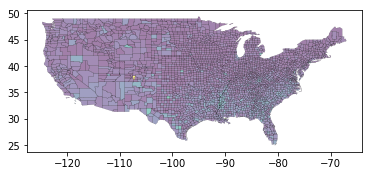

In [7]:
gdf = gpd.GeoDataFrame(df)
gdf.plot('hr90', linewidth=.1) # to prove we're in geopandas

The nice thing with having the code to serialize/deserialize `shapely` objects is that you can publish directly to CARTO (and make CARTO maps) directly from (geo)pandas:

In [8]:
from cartoframes import Layer, styling
cxn.map(layers=Layer('nat', color={'column': 'hr90', 'scheme': styling.sunset(7)}))

In [9]:
cxn.write(gdf,
          encode_geom=True,
          table_name='cartoframes_geopandas',
          overwrite=True)

If you change the geometries locally, the changes propagate back to CARTO:

In [10]:
gdf['geometry'] = gdf.geometry.apply(lambda x: x.buffer(2))
df['geometry'] = df.geometry.apply(lambda x: x.buffer(2))

In [11]:
cxn.write(gdf, encode_geom=True,
          table_name='cartoframes_geopandas_buffered',
          overwrite=True)

In [12]:
gdf.head()

,the_geom,the_geom_webmercator,name,state_name,state_fips,cnty_fips,fips,stfips,cofips,fipsno,...,blk90,gi59,gi69,gi79,gi89,fh60,fh70,fh80,fh90,geometry
cartodb_id,,,,,,,,,,,,,,,,,,,,,
364,0103000000010000004900000013d72ae150dd57c02a78...,0106000020110F00000100000001030000000100000007...,Murray,Minnesota,27,101,27101,27.0,101.0,27101.0,...,0.000000,0.340082,0.414127,0.382432,0.364256,9.146341,5.1,5.566097,4.782767,POLYGON ((-95.45806149657828 46.19699053301913...
1660,01030000000100000047000000c828d722b9fb57c02ced...,0106000020110F00000100000001030000000100000006...,Chautauqua,Kansas,20,019,20019,20.0,19.0,20019.0,...,0.521897,0.368538,0.437940,0.401030,0.395566,9.501188,6.8,7.728495,8.073541,POLYGON ((-95.93317481052065 34.99958301471847...
115,0103000000010000004c000000d1b43b8a3e8b58c02e9d...,0106000020110F0000010000000103000000010000000A...,Becker,Minnesota,27,005,27005,27.0,5.0,27005.0,...,0.071733,0.328578,0.390693,0.374987,0.375178,12.385242,7.2,8.790072,11.961039,POLYGON ((-98.17569213705725 46.72406149358208...
55,0103000000010000004a000000c0248c918d9a58c08a4b...,0106000020110F0000010000000103000000010000000A...,Pennington,Minnesota,27,113,27113,27.0,113.0,27113.0,...,0.082669,0.264746,0.361857,0.357659,0.370818,11.554969,7.1,10.775000,10.980841,POLYGON ((-98.41489065824408 47.46063804640205...
62,0103000000010000005b000000644f2b866ee75cc03ff8...,0106000020110F00000100000001030000000100000035...,Shoshone,Idaho,16,079,16079,16.0,79.0,16079.0,...,0.114852,0.185961,0.296188,0.328998,0.364126,7.810136,5.4,8.762984,12.869565,POLYGON ((-115.6161208556128 49.95441929622074...


In [13]:
cxn.map(layers=[cf.BaseMap('light'),
                cf.Layer('cartoframes_geopandas_buffered', 
                         color='gi69')],
        interactive=False)